<a href="https://colab.research.google.com/github/rsn870/Inversion_with_StyleGANXL/blob/main/Inversion_with_StyleGANXL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/autonomousvision/stylegan_xl.git

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 291 (delta 72), reused 48 (delta 41), pack-reused 192
Receiving objects: 100% (291/291), 6.57 MiB | 33.64 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [3]:
!pip install einops ninja
!pip install timm
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 11.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.4 MB/s 


In [4]:
cd stylegan_xl 

/content/stylegan_xl


Dnnlib works only inside styleganxl folder

In [5]:

import io
import os, time, glob
import pickle
import shutil
import sys
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
from google.colab import files
import dnnlib
import legacy


device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

# Functions (many must be trimmed too)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    !wget -c '{url_or_path}'



Using device: cuda:0


In [6]:
Model = 'Imagenet-512' #@param ["Imagenet-1024", "Imagenet-512", "Imagenet-256", "Imagenet-128", "Pokemon", "FFHQ"]

#@markdown ---

network_url = {
    "Imagenet-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet1024.pkl",
    "Imagenet-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl",
    "Imagenet-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl",
    "Imagenet-128": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet128.pkl",
    "Pokemon-1024": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon1024.pkl",
    "Pokemon-512": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon512.pkl",
    "Pokemon-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/pokemon256.pkl",
    "FFHQ-256": "https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/ffhq256.pkl"
}

network_name = network_url[Model].split("/")[-1]
fetch_model(network_url[Model])

with dnnlib.util.open_url(network_name) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore


zs = torch.randn([10000, G.mapping.z_dim], device=device)
cs = torch.zeros([10000, G.mapping.c_dim], device=device)
for i in range(cs.shape[0]):
  cs[i,i//10]=1
w_stds = G.mapping(zs, cs)
w_stds = w_stds.reshape(10, 1000, G.num_ws, -1)
w_stds=w_stds.std(0).mean(0)[0]
w_all_classes_avg = G.mapping.w_avg.mean(0)

--2022-05-29 05:07:39--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet512.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.29
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1973325502 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet512.pkl’

imagenet512.pkl     100%[===================>]   1.84G  21.3MB/s    in 91s     

2022-05-29 05:09:11 (20.7 MB/s) - ‘imagenet512.pkl’ saved [1973325502/1973325502]

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [ ]:
fetch_model("https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet_centroids.npy")


--2022-05-28 11:16:49--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet_centroids.npy
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.171.125
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.171.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40960128 (39M) [binary/octet-stream]
Saving to: ‘imagenet_centroids.npy’

imagenet_centroids. 100%[===================>]  39.06M  19.3MB/s    in 2.0s    

2022-05-28 11:16:52 (19.3 MB/s) - ‘imagenet_centroids.npy’ saved [40960128/40960128]



In [ ]:
import numpy as np
import torch

centroids = np.load('imagenet_centroids.npy')

centroids = torch.from_numpy(centroids)

In [ ]:
torch.save(centroids, 'centroids_xl.pt')

In [ ]:
centroids.size()

torch.Size([10000, 512])

In [ ]:
decoded_image = G.synthesis((centroids[:10].cuda()).unsqueeze(1).repeat([1, G.num_ws, 1]))


In [ ]:
decoded_image_np = tensor2numpy(decoded_image)
decoded_image_nps = [Image.fromarray(decoded_image_np[i]) for i in range(len(decoded_image))]

In [ ]:
for it in range(len(decoded_image_nps)):
    decoded_image_nps[it].resize((256,256)).save(f'/content/centroids/image_xlc_{it+1}.png')


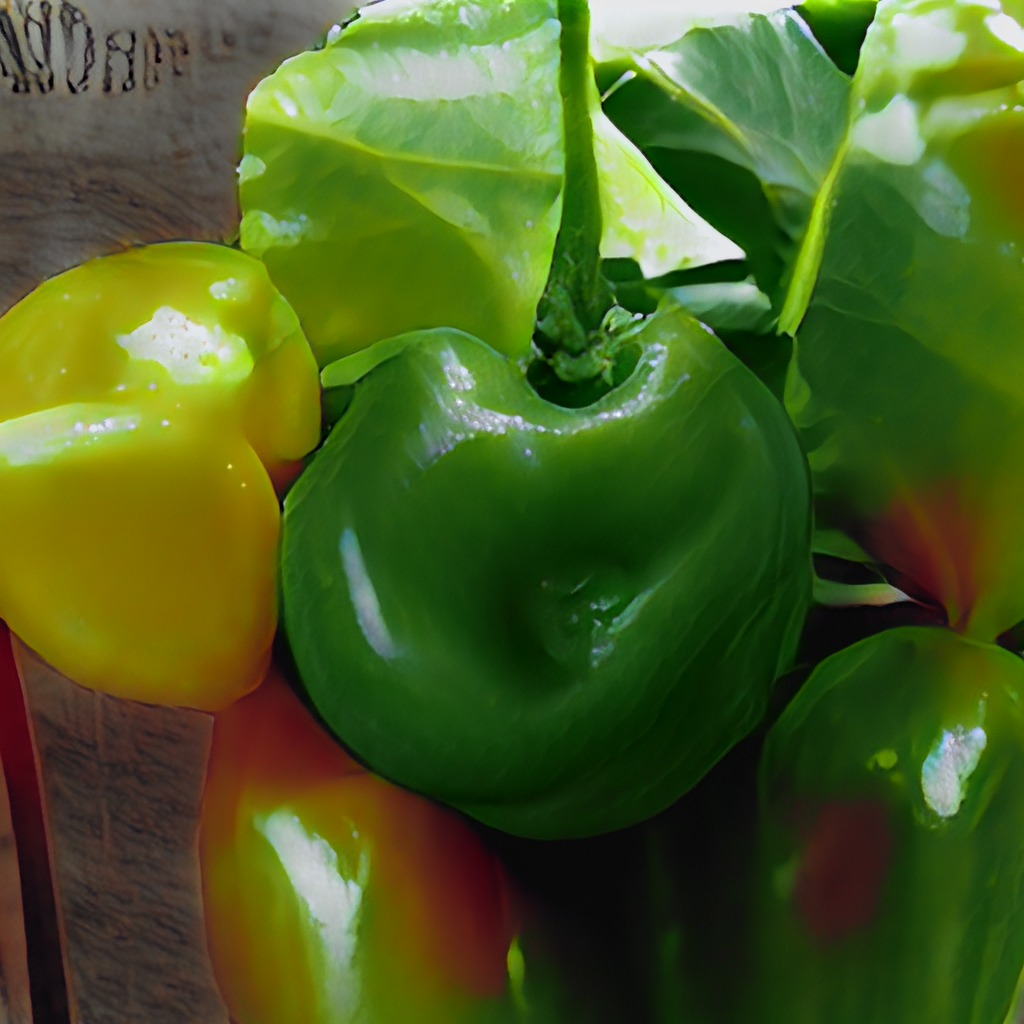

In [ ]:
decoded_image_np.save("")

In [7]:
  def read_image(imagename,image_transforms):

        ims = sorted(os.listdir(imagename))
        image = [Image.open(os.path.join(imagename,path)) for path in ims]
        return [image_transforms(imag).unsqueeze(0) for imag in image]

In [9]:
imagename = '/content/oods'

In [8]:
from torchvision import transforms

In [10]:
image_transforms = transforms.Compose([
                                    transforms.Resize((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [11]:
def tensor2numpy(images):
        """ we assume the shape of image is (1, C, H, W), and it's a cuda pytorch tensor
        """
        images = torch.clamp(images.detach(), min=-1, max=1)
        images = ((images+1)/2)*255
        images = images.permute(0,2,3,1).detach().cpu().numpy().astype('uint8')
        return images


In [14]:
cd ../

/content


In [18]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-j9brff2m
  Running command git clone -q https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-j9brff2m
  Running command git submodule update --init --recursive -q
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4979 sha256=9a0fba858b725e7f570422eb46e67def53072a175ffb92e1d8b798b4f58c60b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-xgxxjiee/wheels/1e/cf/b5/31d11273e162675221f38043989d970cf7c7c8571d4e8d456d
Failed to build lpips-pytorch
    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip

In [19]:
from lpips_pytorch import LPIPS

In [20]:
lpips_criterion =  LPIPS(net_type='alex', version='0.1')

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [21]:
from torch import nn

MSE_criterion = nn.MSELoss()

In [22]:
import os

In [23]:
exppath = '/content/results'

In [ ]:
imagebo = '/content/frames'

In [ ]:
sorted(os.listdir(imagebo))[0]

NameError: ignored

In [24]:
image = read_image(imagename, image_transforms)
        

In [ ]:
cd ../

/content


In [ ]:
ls

frames/  lpips/  results/  sample_data/  stylegan_xl/


In [25]:
learning_rate = 5e-2

In [26]:
for i in tqdm(range(len(image))):
            a = torch.randn([1, 512], device=device)*0.6 + w_all_classes_avg*0.4
            latentcode = ((a-w_all_classes_avg)/w_stds)
            latentcode.requires_grad = True
            optimizer = torch.optim.Adam([latentcode], lr=learning_rate)
            for step in tqdm(range(1000)):
                decoded_image = G.synthesis((latentcode* w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
                decoded_image = F.interpolate(decoded_image, size=(256, 256), mode='bicubic').cpu()
                lpipsloss = lpips_criterion(decoded_image, image[i].cpu())
                mseloss = MSE_criterion(decoded_image, image[i].cpu())

                loss = lpipsloss + mseloss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                dataitems = {'lpipsloss': lpipsloss, 
                         'mseloss': mseloss}
                if step % 50 == 0 or step == 1000:
                    decoded_image_np = tensor2numpy(decoded_image.clamp(-1,1))
                    decoded_image_np = Image.fromarray(decoded_image_np[0])
                    os.makedirs(f'{exppath}/images/{i+1}',exist_ok=True)
                    decoded_image_np.save(f'{exppath}/images/{i+1}/{step}.png')

            os.makedirs(f'{exppath}/latent/{i+1}',exist_ok=True)

            torch.save(latentcode.detach().cpu(),f'{exppath}/latent/{i+1}/latent_{i+1}.pt')
            


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:

latentcode = torch.load('/content/results/latent/1/latent_1.pt')
latentcode.requires_grad = True
            


In [ ]:
optimizer = torch.optim.Adam([latentcode], lr=learning_rate)


In [ ]:
latentcode = latentcode.cuda()

In [63]:
for step in tqdm(range(1000,3000)):
                decoded_image = G.synthesis((latentcode* w_stds + w_all_classes_avg).unsqueeze(1).repeat([1, G.num_ws, 1]))
                decoded_image = F.interpolate(decoded_image, size=(256, 256), mode='bicubic').cpu()
                lpipsloss = lpips_criterion(decoded_image, image[i].cpu())
                mseloss = MSE_criterion(decoded_image, image[i].cpu())

                loss = lpipsloss + mseloss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                dataitems = {'lpipsloss': lpipsloss, 
                         'mseloss': mseloss}
                if step % 50 == 0 or step == 2000:
                    decoded_image_np = tensor2numpy(decoded_image.clamp(-1,1))
                    decoded_image_np = Image.fromarray(decoded_image_np[0])
                    os.makedirs(f'{exppath}/images/{1}',exist_ok=True)
                    decoded_image_np.save(f'{exppath}/images/{1}/{step}.png')


torch.save(latentcode.detach().cpu(),f'{exppath}/latent/{1}/latent_mod.pt')
            


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
os.makedirs(f'{exppath}/latent/{i+1}',exist_ok=True)

torch.save(latentcode.detach().cpu(),f'{exppath}/latent/{i+1}/latent_{i+1}.pt')